## Imports

In [87]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_metric, concatenate_datasets, load_from_disk
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

## Model

In [88]:
model_name = 'distilbert-base-multilingual-cased'

## Tokenizer

In [89]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [90]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [91]:
NUM_EPOCHS = 10
BATCH_SIZE = 4
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-combined_data-{NUM_EPOCHS}_epochs'
OVERWRITE_OUTPUT_DIR = True # only for first experiments
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [92]:
# check gpu
torch.cuda.is_available()

True

In [93]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and prepare data

### Combine Germeval14, Smartdata, and Telegram train splits to create training data

In [94]:
germeval = load_from_disk('/home/eli/data/data_prepared_for_tf/germeval14/')
smartdata = load_from_disk('/home/eli/data/data_prepared_for_tf/smartdata/')
telegram = load_from_disk('/home/eli/data/data_prepared_for_tf/telegram/')
assert germeval['train'].features.type == smartdata['train'].features.type
assert germeval['train'].features.type == telegram['train'].features.type

In [95]:
train_ds = concatenate_datasets([germeval['train'], smartdata['train'], telegram['train']])

### Shuffle training data

In [96]:
train_ds = train_ds.shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/eli/data/data_prepared_for_tf/germeval14/train/cache-8632e677d3a249b4.arrow


### Use Telegram test split as validation set

In [97]:
eval_ds = telegram['test']

### Methods for processing

In [98]:
def get_indices_and_tags(ds, tag_name='ner_tags'):
    tags = ds.features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

### Methods for evaluation

In [99]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [100]:
tags, index2tag, tag2index = get_indices_and_tags(train_ds)

In [101]:
train_encoded = encode_dataset(train_ds)

100%|███████████████████████████████████████████| 27/27 [00:05<00:00,  4.56ba/s]


In [78]:
eval_encoded = encode_dataset(eval_ds)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.59ba/s]


## model initialization and config

In [102]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=tags.num_classes, 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [103]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config).to(device)

## Training

In [104]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [105]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=train_encoded,
    eval_dataset=eval_encoded,
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [107]:
%time
trainer.train()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=32890, training_loss=0.04292633553049999, metrics={'train_runtime': 2273.5991, 'train_samples_per_second': 115.724, 'train_steps_per_second': 28.932, 'total_flos': 1.71914871692544e+16, 'train_loss': 0.04292633553049999, 'epoch': 5.0})

In [113]:
trainer.evaluate()

{'eval_loss': 0.25429269671440125,
 'eval_f1': 0.6634382566585956,
 'eval_precision': 0.6401869158878505,
 'eval_recall': 0.6884422110552764,
 'eval_accuracy': 0.9227441285537701,
 'eval_runtime': 0.2806,
 'eval_samples_per_second': 178.188,
 'eval_steps_per_second': 46.329,
 'epoch': 5.0}

In [114]:
eval_df = get_training_history(trainer)

In [115]:
eval_df

epoch  training_loss  validation_loss        f1  precision    recall  \
0       1         0.0943         0.285416  0.610687        NaN       NaN   
1       1         0.0943         0.285416  0.610687   0.618557  0.603015   
2       2         0.0507         0.254293  0.663438        NaN       NaN   
3       2         0.0507         0.254293  0.663438   0.640187  0.688442   
4       3         0.0329         0.331771  0.661692        NaN       NaN   
5       3         0.0329         0.331771  0.661692   0.655172  0.668342   
6       4         0.0221         0.354799  0.654822        NaN       NaN   
7       4         0.0221         0.354799  0.654822   0.661538  0.648241   
8       5         0.0147         0.382817  0.676471        NaN       NaN   
9       5         0.0147         0.382817  0.676471   0.660287  0.693467   
10      5         0.0147         0.254293  0.663438        NaN       NaN   
11      5         0.0147         0.254293  0.663438   0.640187  0.688442   
12      5         0.0147         0.254293  0.663438   0.640187  0.688442   

    accuracy  
0        NaN  
1   0.914091  
2        NaN  
3   0.922744  
4        NaN  
5   0.923980  
6        NaN  
7   0.920890  
8        NaN  
9   0.919654  
10       NaN  
11  0.922744  
12  0.922744

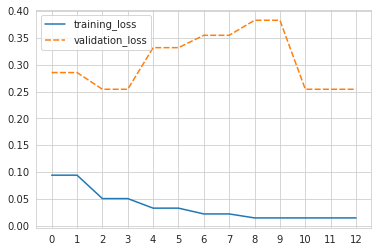

In [116]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

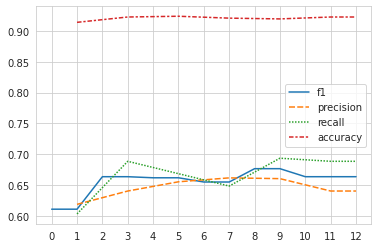

In [118]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()